### Example: Vehicle Localization
Sample code implementing max-product and sum-product belief propagation

In [15]:
# setup model
import sys
import numpy as np
from numpy import array as arr

# general parameters
max_product = 1 # max-product vs. sum-product
num_iters = 10

# model parameters
unary = np.array([[0.7,0.1,0.2],[0.7,0.2,0.1],[0.2,0.1,0.7],[0.7,0.2,0.1],
                  [0.2,0.6,0.2],[0.1,0.8,0.1],[0.4,0.3,0.3],[0.1,0.8,0.1],
                  [0.1,0.1,0.8],[0.1,0.5,0.4]])
pairwise = arr([[0.8,0.2,0.0],[0.2,0.6,0.2],[0.0,0.2,0.8]])
[num,dim] = unary.shape
np.set_printoptions(precision=2)

# print unaries
print "=============== INPUT ===================="
print "unary potentials:"
print unary
print "pairwise potential:"
print pairwise

=============== INPUT ====================
unary potentials:
[[ 0.7  0.1  0.2]
 [ 0.7  0.2  0.1]
 [ 0.2  0.1  0.7]
 [ 0.7  0.2  0.1]
 [ 0.2  0.6  0.2]
 [ 0.1  0.8  0.1]
 [ 0.4  0.3  0.3]
 [ 0.1  0.8  0.1]
 [ 0.1  0.1  0.8]
 [ 0.1  0.5  0.4]]
pairwise potential:
[[ 0.8  0.2  0. ]
 [ 0.2  0.6  0.2]
 [ 0.   0.2  0.8]]


In [16]:
# initialize variables and factors
variables = dim*np.ones(num,dtype=np.int64)
factors = []

# unary
for i in range(num):
    factors.append({'vars':arr([i]), 'vals':arr(unary[i])})

# pairwise
for i in range(num-1):
    factors.append({'vars':arr([i,i+1]), 'vals':pairwise})

# init all messages to zero
msg_fv = {}
msg_vf = {}
ne_var = [[] for i in range(num)]
for [f_idx,f] in enumerate(factors):
    for v_idx in f['vars']:
        msg_fv[(f_idx,v_idx)] = np.ones(variables[v_idx])
        msg_vf[(v_idx,f_idx)] = np.ones(variables[v_idx])
        ne_var[v_idx].append(f_idx)

In [17]:
# run inference
for it in range(num_iters):
  
    # for all factor-to-variable messages do
    for [key,msg] in msg_fv.items():
        f_idx = key[0]
        v_idx = key[1]
        f_vars = factors[f_idx]['vars']
        f_vals = factors[f_idx]['vals']

        # unary factor
        if np.size(f_vars)==1:
              msg_fv[(f_idx,v_idx)] = f_vals

        # pairwise factor
        else:

            # target variable = first variable of factor
            if v_idx==f_vars[0]:
                msg_vf_mat = np.tile(msg_vf[(f_vars[1],f_idx)],(variables[v_idx],1))
                if max_product:
                    msg_fv[(f_idx,v_idx)] = np.multiply(msg_vf_mat.transpose(),f_vals.transpose()).max(0)
                else:
                    msg_fv[(f_idx,v_idx)] = np.multiply(msg_vf_mat.transpose(),f_vals.transpose()).sum(0)

            # target variable = second variable of factor
            else:
                msg_vf_mat = np.tile(msg_vf[(f_vars[0],f_idx)],(variables[v_idx],1))
                if max_product:
                    msg_fv[(f_idx,v_idx)] = np.multiply(msg_vf_mat.transpose(),f_vals).max(0)
                else:
                    msg_fv[(f_idx,v_idx)] = np.multiply(msg_vf_mat.transpose(),f_vals).sum(0)

    # for all variable-to-factor messages do
    for [key,msg] in msg_vf.items():
        v_idx = key[0]
        f_idx = key[1]
        f_vars = factors[f_idx]['vars']
        f_vals = factors[f_idx]['vals']

        msg_vf[(v_idx,f_idx)] = np.ones((variables[v_idx]))
        for f_idx2 in ne_var[v_idx]:
            if f_idx2 != f_idx:
                msg_vf[(v_idx,f_idx)] = np.multiply(msg_vf[(v_idx,f_idx)],msg_fv[(f_idx2,v_idx)])

# normalize marginals and compute map state
marginals = np.zeros([num,dim])
for v_idx in range(num):
    marginals[v_idx] = np.ones((variables[v_idx]))
    for f_idx in ne_var[v_idx]:
        marginals[v_idx] = np.multiply(marginals[v_idx],msg_fv[(f_idx,v_idx)])
        marginals[v_idx] = marginals[v_idx]/np.sum(marginals[v_idx])

# output marginals / map state  
print "=============== OUTPUT ===================="
if max_product:
    print "max marginals:"
    print marginals
    print "map estimate:"
    print np.argmax(marginals,axis=1)
else:
    print "marginals:"
    print marginals

=============== OUTPUT ====================
max marginals:
[[ 0.94  0.03  0.03]
 [ 0.95  0.02  0.03]
 [ 0.9   0.07  0.03]
 [ 0.81  0.17  0.02]
 [ 0.31  0.69  0.01]
 [ 0.11  0.86  0.03]
 [ 0.11  0.73  0.16]
 [ 0.01  0.81  0.18]
 [ 0.03  0.25  0.72]
 [ 0.02  0.25  0.72]]
map estimate:
[0 0 0 0 1 1 1 1 2 2]


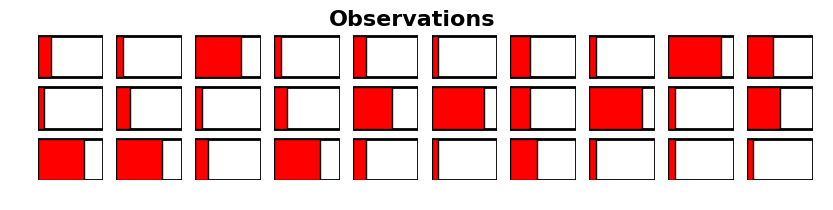

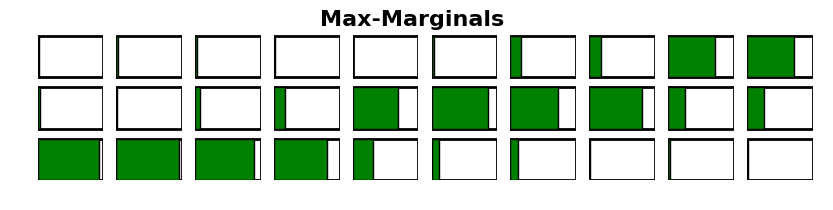

In [18]:
# plot observations and marginals graphically
import matplotlib.pyplot as plt
import time

plt.close()

# plot observations
f, axarr = plt.subplots(1,10,figsize=(10,2))
plt.suptitle('Observations', fontsize=16, fontweight='bold')
for i in range(num):
    axarr[i].barh([0,1,2],np.ones([3,1]),color='white',edgecolor='black',linewidth=2)
    axarr[i].barh([0,1,2],unary[i],color='red')
    axarr[i].axis('off')
    
# plot marginals
f, axarr = plt.subplots(1,10,figsize=(10,2))
if max_product:
    plt.suptitle('Max-Marginals', fontsize=16, fontweight='bold')
else:
    plt.suptitle('Marginals', fontsize=16, fontweight='bold')
for i in range(num):
    axarr[i].barh([0,1,2],np.ones([3,1]),color='white',edgecolor='black',linewidth=2)
    axarr[i].barh([0,1,2],marginals[i],color='green')
    axarr[i].axis('off')
    
plt.show()

